# Data Scientist Professional Practical Exam

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!

# Predicting short-stay nightly rents
## Summary

Our task was to build a model that can predict nightly rents for properties on a short-stay letting platform. The success criteria for this task was predicting rental values within USD25 of the true value.

Using a linear regression model, it was possible to predict rental values for property listings within USD25 of the true value in just over 25% of cases. As things stand, the model doesn't meet the success criteria.

My recommendations to the business are:
- Introduce a tool to predict nightly rents that outputs a rent range of USD100 (USD50 either way), which the model suggests will be accurate in more than 50% of cases;
- Continue to collect data to build a larger training set; 
- Extend data collection to other geographies; and
- Collect data on listing date to account for price variability through the year.

## 1. Data validation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read the rental data into a DataFrame and perform initial inspection
data = pd.read_csv('data/rentals.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


The data contains 8,111 entries across 9 total fields. Two of the nine fields contain nulls: bathrooms and bedrooms.

In [4]:
data[data['bedrooms'].isna()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
269,431862,37.78321,-122.41969,Apartment,Entire home/apt,1.0,NaN,30,$124.00
6301,32183178,37.78883,-122.48640,House,Entire home/apt,3.5,NaN,30,$650.00
7786,38329898,37.78347,-122.41669,Apartment,Entire home/apt,1.0,NaN,30,$75.00
7840,38550933,37.78979,-122.41994,Apartment,Entire home/apt,1.0,NaN,30,$108.00


In [5]:
data[data['bathrooms'].isna()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
139,144978,37.79336,-122.42506,Apartment,Private room,NaN,1.0,30,$56.00
181,229240,37.79341,-122.40340,Hostel,Shared room,NaN,1.0,1,$45.00
196,259621,37.79470,-122.40374,Hostel,Shared room,NaN,1.0,1,$45.00
197,259622,37.79441,-122.40473,Hostel,Shared room,NaN,1.0,1,$45.00
267,430692,37.75906,-122.40761,Apartment,Private room,NaN,1.0,31,$68.00
352,596042,37.79384,-122.42436,Apartment,Private room,NaN,1.0,30,$63.00
434,785901,37.79313,-122.40443,Hostel,Shared room,NaN,1.0,1,$45.00
435,786492,37.79421,-122.40310,Hostel,Shared room,NaN,1.0,1,$45.00
436,786506,37.79260,-122.40339,Hostel,Shared room,NaN,1.0,1,$45.00
539,1031899,37.74833,-122.42621,Apartment,Entire home/apt,NaN,1.0,30,$127.00


Four records do not include information on the number of bedrooms. These records should be dropped.

All 12 records with missing bathroom data have one bedroom. These should be filled with the mode number of bathrooms for one-bedroom properties.

In [6]:
data = data.dropna(subset=['bedrooms'])

In [7]:
mode_baths = data[data['bedrooms']==1]['bathrooms'].mode()
print(mode_baths)

0    1.0
Name: bathrooms, dtype: float64


In [8]:
data = data.fillna({'bathrooms':1})

In [9]:
data.describe(include="all")

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
count,8.107000e+03,8107.000000,8107.000000,8107,8107,8107.000000,8107.000000,8.107000e+03,8107
unique,NaN,NaN,NaN,26,4,NaN,NaN,NaN,526
top,NaN,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,$150.00
freq,NaN,NaN,NaN,3240,4768,NaN,NaN,NaN,271
mean,2.024209e+07,37.766044,-122.430104,NaN,NaN,1.395276,1.345874,1.235134e+04,NaN
std,1.228267e+07,0.022938,0.026966,NaN,NaN,0.922556,0.925298,1.110631e+06,NaN
min,9.580000e+02,37.704630,-122.513060,NaN,NaN,0.000000,0.000000,1.000000e+00,NaN
25%,8.905668e+06,37.751445,-122.442830,NaN,NaN,1.000000,1.000000,2.000000e+00,NaN
50%,2.161033e+07,37.769140,-122.424670,NaN,NaN,1.000000,1.000000,4.000000e+00,NaN
75%,3.118834e+07,37.785655,-122.410610,NaN,NaN,1.500000,2.000000,3.000000e+01,NaN


The latitude and longitude data show these property listings are contained within a small area. Cross-referencing with Google Maps shows they are in downtown San Francisco. 

The data contains 26 unique property types. That suggests the categories are either too specific or there are duplicate, misspelled categories.

Room type has a more reasonable number of categories, which should be investigated.

At least some properties appear to have erroneous entries for number of bathrooms or bedrooms. 

At least one record says it must be let for at least one hundred million nights. Given the nature of this platform, listings with minimum letting periods over a month are Intuition suggests the minimum_nights field will not provide useful information for predicting price per night, so it may not be relevant for this analysis. 

The price column has been read as the object data type because some or all of the entries start with a dollar sign and some contain commas. This field should be converted to a numeric data type such as float or integer.

In [10]:
data['price_float'] = data['price'].str.replace("$","").str.replace(",","").astype("float")
data = data.drop('price', axis=1)

In [11]:
data.describe(include="all")

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price_float
count,8.107000e+03,8107.000000,8107.000000,8107,8107,8107.000000,8107.000000,8.107000e+03,8107.000000
unique,NaN,NaN,NaN,26,4,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,3240,4768,NaN,NaN,NaN,NaN
mean,2.024209e+07,37.766044,-122.430104,NaN,NaN,1.395276,1.345874,1.235134e+04,225.400271
std,1.228267e+07,0.022938,0.026966,NaN,NaN,0.922556,0.925298,1.110631e+06,412.320789
min,9.580000e+02,37.704630,-122.513060,NaN,NaN,0.000000,0.000000,1.000000e+00,0.000000
25%,8.905668e+06,37.751445,-122.442830,NaN,NaN,1.000000,1.000000,2.000000e+00,100.000000
50%,2.161033e+07,37.769140,-122.424670,NaN,NaN,1.000000,1.000000,4.000000e+00,150.000000
75%,3.118834e+07,37.785655,-122.410610,NaN,NaN,1.500000,2.000000,3.000000e+01,240.000000


There are some erroneous entries with price zero, which should be dropped. $10,000 is a possible nightly rent (plausible in San Francisco) but unlikely to be helpful in predicting prices for most properties.

In [12]:
# Remove entries with no price information
cleaned_data = data[data['price_float']>0]

In [13]:
# Count how many records have minimum stays over one month
data[data['minimum_nights']>30].count()

id                313
latitude          313
longitude         313
property_type     313
room_type         313
bathrooms         313
bedrooms          313
minimum_nights    313
price_float       313
dtype: int64

If the minimum number of nights for which you can book a property is 365, that is a long-term rental and it shouldn't be on the site. There are 313 listings with a minimum stay over 30 days, which should be dropped.

In [14]:
cleaned_data = cleaned_data[cleaned_data['minimum_nights']<=30]

<AxesSubplot:xlabel='minimum_nights', ylabel='Count'>

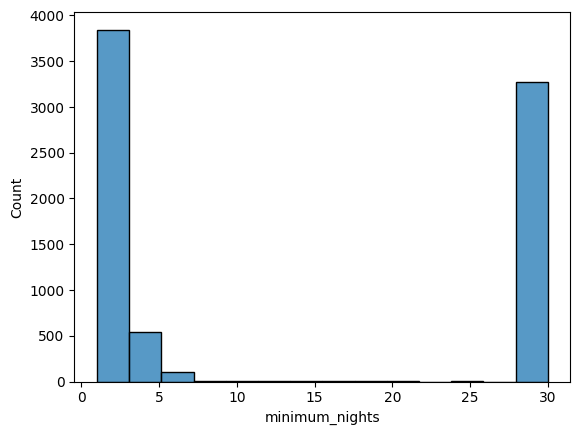

In [15]:
sns.histplot(data=cleaned_data, x='minimum_nights')

In [16]:
# View distribution of bedroom numbers
cleaned_data.bedrooms.value_counts()

1.0     4648
2.0     1420
0.0      822
3.0      667
4.0      189
5.0       36
6.0        8
14.0       1
7.0        1
8.0        1
Name: bedrooms, dtype: int64

There is 1 record each with 7, 8, and 14 bedrooms. Drop these.

In [17]:
cleaned_data = cleaned_data[cleaned_data['bedrooms']<7]

<AxesSubplot:xlabel='count', ylabel='property_type'>

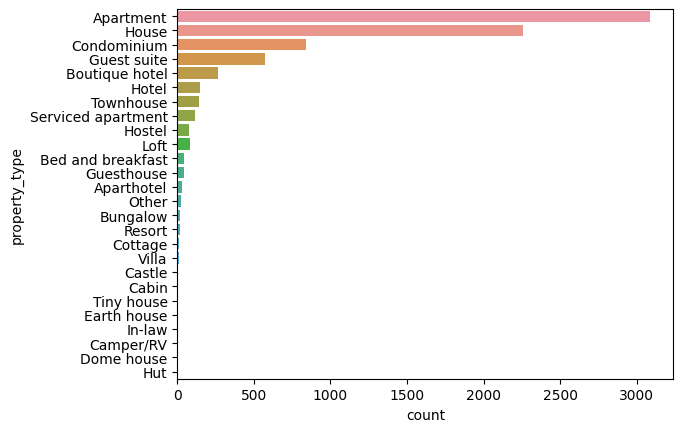

In [18]:
sns.countplot(data=cleaned_data, y="property_type", order=data['property_type'].value_counts().index)

There are many different property types. Before investing the effort to clean this field, it is worth checking whether there is a meaningful difference in rent by property type.

In [19]:
data.groupby('property_type').agg({'price_float':'mean', 'property_type':'count'}
                                 ).rename(columns={'price_float':'Average price', 'property_type':"Count"}
                                         ).sort_values(by='Count', ascending=False)

,Average price,Count
property_type,,
Apartment,204.716667,3240
House,224.258539,2313
Condominium,273.226457,892
Guest suite,160.956672,577
Boutique hotel,460.460674,267
Hotel,265.490446,157
Townhouse,292.528169,142
Serviced apartment,226.355372,121
Hostel,69.782609,92


<AxesSubplot:xlabel='price_float', ylabel='property_type'>

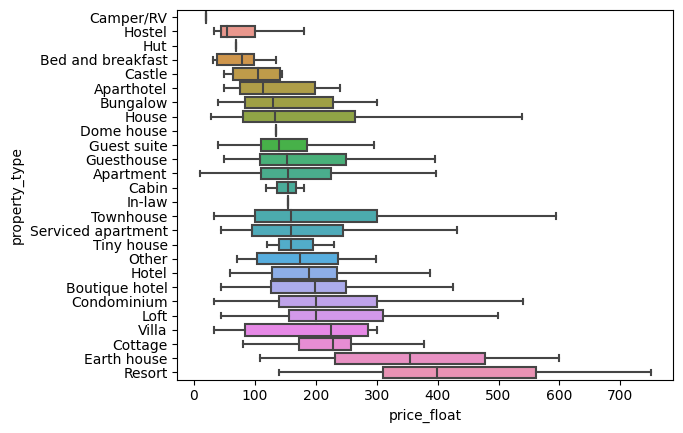

In [20]:
sns.boxplot(data=cleaned_data, y='property_type', x='price_float', showfliers=False, 
            order = cleaned_data.groupby('property_type')['price_float'].median().sort_values().index)

Most listings are for apartments or houses.

There appears to be limited correlation between property type and price, with a few exceptions. However, these exceptions tend to have low frequency. For example, resorts tend to be more expensive, but there are only 14 listings for resorts. Castles seem to be cheaper than average, but there are just four listings.



Logical categories for property type would include "Apartment", "House", "Guest suite", and "Hotel". Many of the less frequent labels will fit into these four categories.

- The "Apartment" category should include "Condominium" and "Loft".
- The "House" category should include "Townhouse", "Bungalow", "Cottage", and "Villa".
- The "Hotel" category should include "Boutique hotel", "Hostel", "Bed and breakfast", "Guesthouse", and "Aparthotel".

For now, I will drop "Hotels" from the data as the typical user is unlikely to be an aspiring hotelier. We will keep the relabeling in case we want to come back to it.

The long tail of other property types ("Castle", "Hut", etc.) have very low frequency. On balance, I feel it is appropriate to drop these entries.

In [21]:
# Relabel synonymous property types and convert to category data type

types = {"Condominium": "Apartment", "Loft":"Apartment", \
         "Townhouse":"House", "Bungalow":"House", "Cottage":"House", "Villa":"House", \
         "Boutique hotel":"Hotel", "Hostel":"Hotel", "Bed and breakfast":"Hotel", "Guesthouse":"Hotel", "Aparthotel":"Hotel", "Serviced apartment":"Hotel"}

cleaned_data['cleaned_prop_type'] = cleaned_data['property_type'].replace(types, regex=True)

cleaned_data = cleaned_data[cleaned_data['cleaned_prop_type'].isin(['Apartment','House','Guest suite'])].drop('property_type', axis=1)
cleaned_data['cleaned_prop_type'] = cleaned_data['cleaned_prop_type'].astype('category')

<AxesSubplot:xlabel='count', ylabel='cleaned_prop_type'>

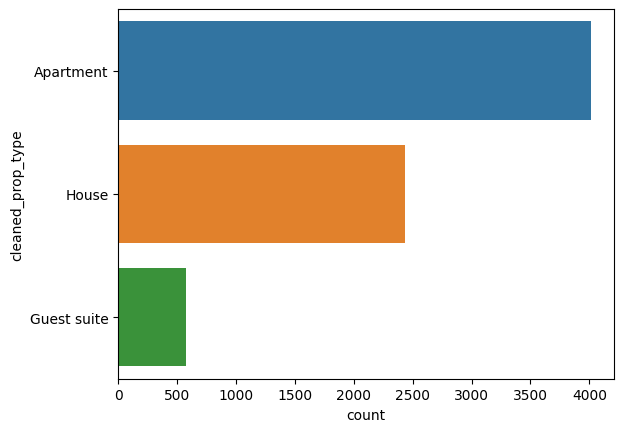

In [22]:
sns.countplot(data=cleaned_data, y='cleaned_prop_type', order=['Apartment','House','Guest suite'])

<AxesSubplot:xlabel='price_float', ylabel='cleaned_prop_type'>

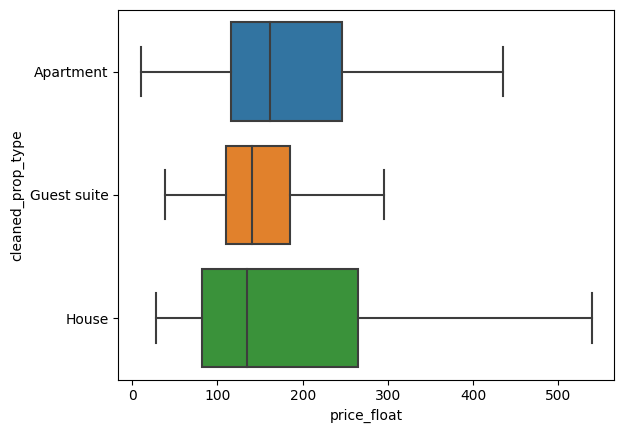

In [23]:
sns.boxplot(data=cleaned_data, y='cleaned_prop_type', x='price_float', showfliers=False)

We're going to build a model on this, so we should encode the property types as fields later.

On initial inspection, there does not appear to be a meaningful difference between prices by property type.

<AxesSubplot:xlabel='count', ylabel='room_type'>

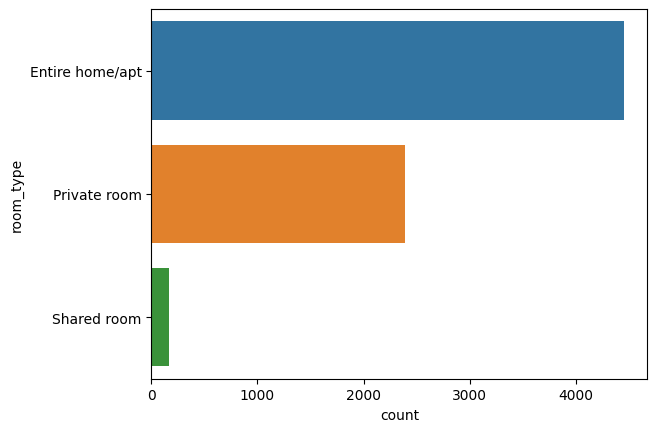

In [24]:
sns.countplot(data=cleaned_data, y='room_type')

In [25]:
cleaned_data.room_type.value_counts()

Entire home/apt    4454
Private room       2395
Shared room         168
Name: room_type, dtype: int64

<AxesSubplot:xlabel='price_float', ylabel='room_type'>

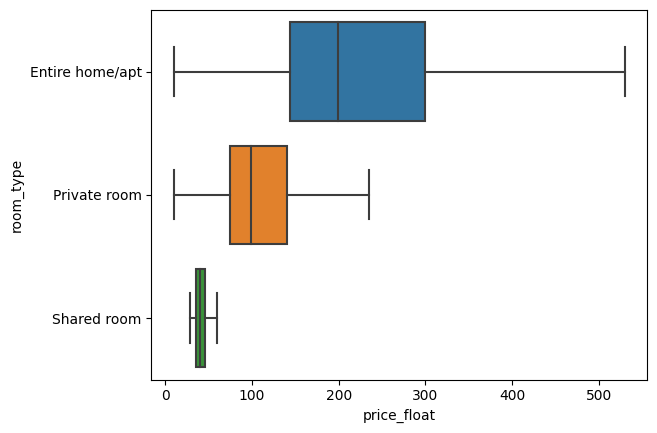

In [26]:
sns.boxplot(data=cleaned_data, y='room_type', x='price_float', showfliers=False)

The room type data contain three labels, all of which make logical sense. There appears to be a clear difference between rent distributions for different room types.

There are only 191 "Shared room" listings available. I'll keep the data in for now, but intuition suggests this is a different kind of product from listings where a whole property or private room is available.

Latitude and longitude should be normalized before including in any models.

In [27]:
cleaned_data['latitude'] = (cleaned_data['latitude']-cleaned_data['latitude'].min())/(cleaned_data['latitude'].max()-cleaned_data['latitude'].min())
cleaned_data['longitude'] = (cleaned_data['longitude']-cleaned_data['longitude'].min())/(cleaned_data['longitude'].max()-cleaned_data['longitude'].min())

In [28]:
cleaned_data.corr()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price_float
id,1.000000,0.007614,0.035876,0.072799,-0.058183,0.133773,-0.006408
latitude,0.007614,1.000000,0.140856,0.077770,-0.067115,0.267255,0.090261
longitude,0.035876,0.140856,1.000000,-0.000815,-0.081346,0.156805,0.020029
bathrooms,0.072799,0.077770,-0.000815,1.000000,0.432526,0.078513,0.231567
bedrooms,-0.058183,-0.067115,-0.081346,0.432526,1.000000,-0.109715,0.439175
minimum_nights,0.133773,0.267255,0.156805,0.078513,-0.109715,1.000000,-0.142347
price_float,-0.006408,0.090261,0.020029,0.231567,0.439175,-0.142347,1.000000


id doesn't correlate strongly with any other variables, nor would we expect it to. It should be excluded from any analysis.

There is only weak correlation between price and latitude and very weak correlation between price and longitude. One might expect high value areas to be clustered together, but that relationship won't usually be linear. One possible route could be to use k_means to cluster listing locations, then use that classification as an input to the model.

As one might expect, there is some correlation between price and the number of bedrooms/bathrooms. There is, however, also correlation between the number of bedrooms and number of bathrooms.

There is very weak correlation between the minimum number of nights stayed and the price. That suggests our earlier intuition was right: that minimum_nights is not a useful parameter for predicting price.

### Summary of data validation

- Price data was converted from object to float data type
- Entries with price zero were removed
- Records with no information on number of bedrooms were removed
- Records with no information on number of bathrooms had bathroom numbers imputed by using the modal value
- Records with a minimum stay duration over 30 days were removed
- Property types were grouped and converted to the category data type; hotels were removed from the data
- Latitude and longitude data were normalized

## 2. Data visualization

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

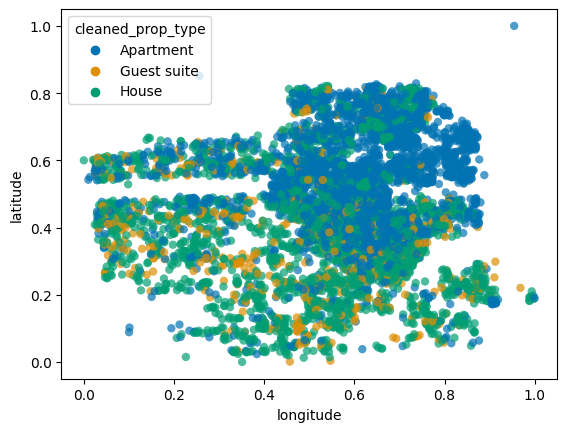

In [29]:
sns.scatterplot(data=cleaned_data, x='longitude', y='latitude', hue='cleaned_prop_type', palette='colorblind', linewidth=0, alpha=0.7)

The shape of the point distribution confirms that the data covers downtown San Francisco.

The outlier to the northeast is on Treasure Island. This is unusual, but not implausible.

Records to the south are more likely to be houses, records to the north are more likely to be apartments.

<AxesSubplot:xlabel='latitude', ylabel='price_float'>

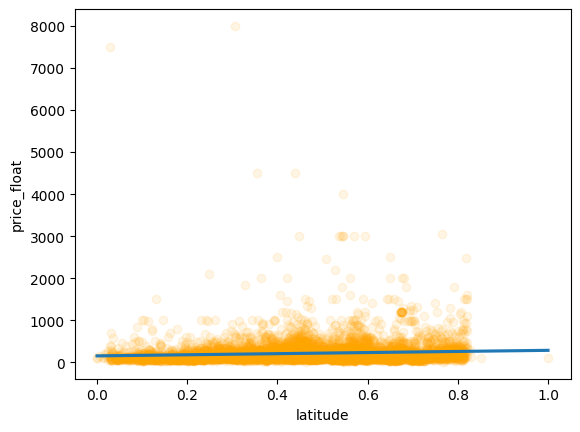

In [30]:
sns.regplot(data=cleaned_data, x='latitude', y='price_float', scatter_kws={'alpha':0.1, 'color':'orange'})

<AxesSubplot:xlabel='longitude', ylabel='price_float'>

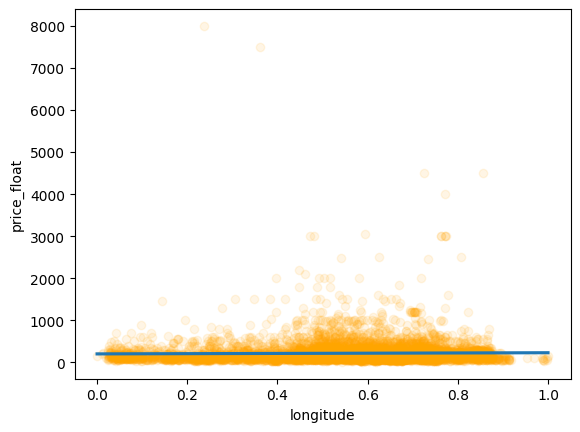

In [31]:
sns.regplot(data=cleaned_data, x='longitude', y='price_float', scatter_kws={'alpha':0.1, 'color':'orange'})

There appears to be no clear relationship between longitude and price.

There is a weak correlation between latitude and price, but this may be because there is a greater proportion of apartments in the north and houses in the south.

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

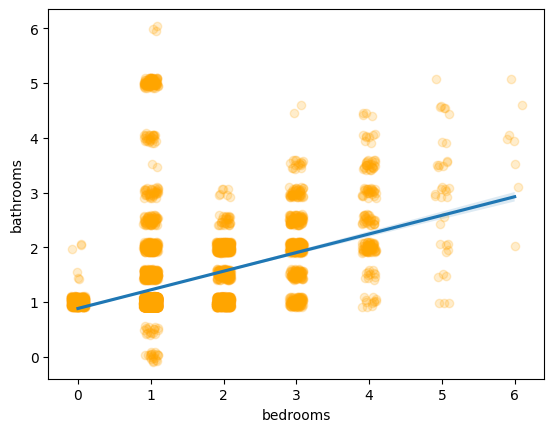

In [32]:
# Visualize relationship between bedrooms and bathrooms
sns.regplot(data=cleaned_data, y='bathrooms', x='bedrooms', x_jitter=0.1, y_jitter=0.1, scatter_kws={'color':"orange",'alpha':0.2})

Most listings have 1 or 2 bathrooms; number of bathrooms tends to scale with number of bedrooms.

There appear to be many listings with 1 bedroom and 5 bathrooms. This is fairly implausible and warrants investigation.

Non-integer numbers of bathrooms appear common. This may be due to a quirk to how bathrooms are reported, e.g. perhaps an en-suite is recorded as a half bathroom.

<AxesSubplot:xlabel='bedrooms', ylabel='Count'>

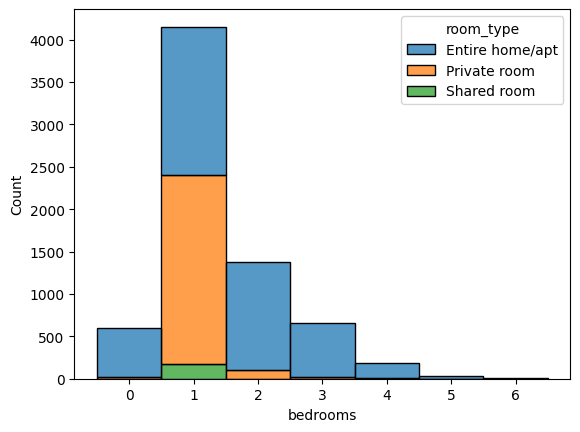

In [33]:
sns.histplot(data=cleaned_data, x='bedrooms', hue='room_type', discrete=True, multiple="stack")

On first glance, one might be concerned that there are "Private room" listings with more than one bedroom. On reflection, this is fine: it's likely to represent properties where someone's letting out more than one bedroom but not exclusive use of the property.

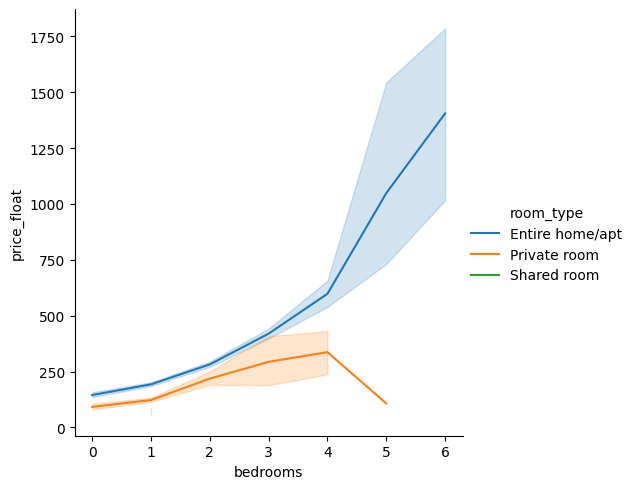

In [34]:
sns.relplot(data=cleaned_data, x='bedrooms', y='price_float', kind='line', hue='room_type')

In [35]:
cleaned_data = cleaned_data[(cleaned_data['room_type'] != "Private room") | (cleaned_data['bedrooms'] != 5)]

The relationship between listing price and the number of bedrooms scales as one might expect: larger properties command higher rents.

Just one "Private room" listing had 5 bedrooms: that record was dropped.

<AxesSubplot:xlabel='bathrooms', ylabel='price_float'>

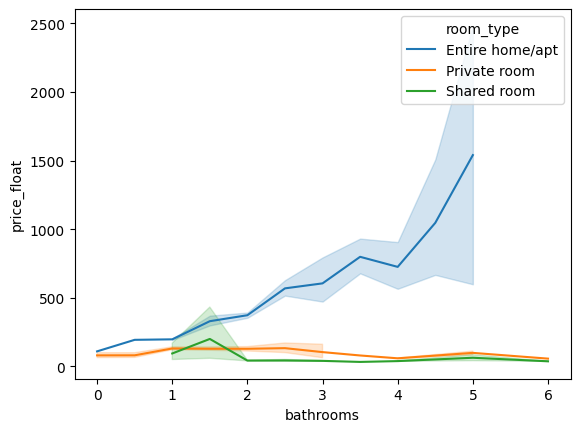

In [36]:
sns.lineplot(data=cleaned_data, x='bathrooms', y='price_float', hue='room_type')

When renting an entire home, more bathrooms generally suggest higher price.

The same is not true of private rooms or shared rooms.

Three ways to deal with this: separate models for entire homes versus private/shared rooms (not unreasonable!), filling the private/shared rooms bathroom fields so they're all zeroes, or use decision trees, which could account for this kind of behavior.

<AxesSubplot:xlabel='minimum_nights', ylabel='price_float'>

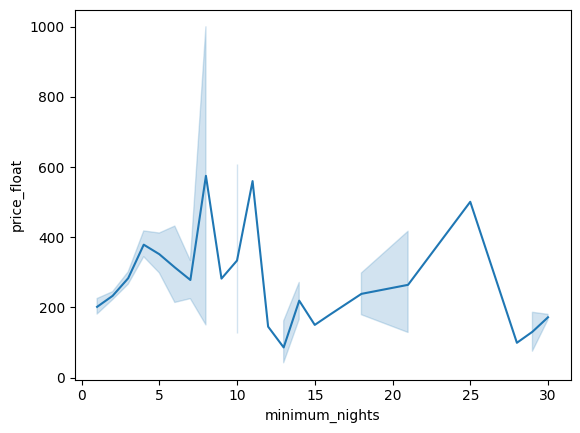

In [37]:
sns.lineplot(data=cleaned_data, x='minimum_nights', y='price_float')

There doesn't appear to be a meaningful relationship between the minimum stay at a property and its nightly price, as expected.

In [38]:
cleaned_data = cleaned_data.drop('minimum_nights', axis=1)

<AxesSubplot:xlabel='price_float', ylabel='Proportion'>

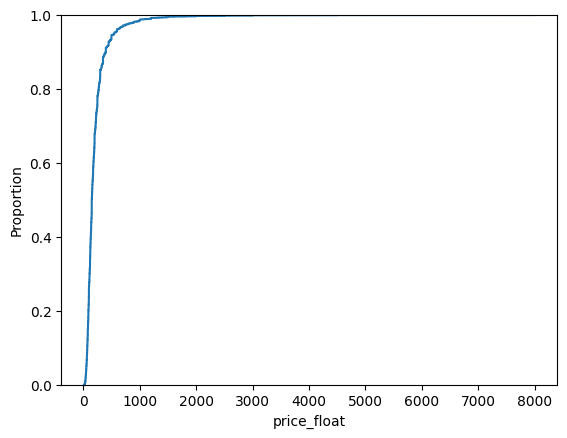

In [39]:
sns.ecdfplot(data=cleaned_data, x='price_float')

More than 90% of records charge less than $1,000 per night.

### Summary of exploratory analysis

- Properties with more bedrooms command higher rents
- Properties with more bedrooms tend to have more bathrooms
- Most "Private room" and "Shared room" records have one bedroom; "Entire house/apt" listings have a range of sizes
- A greater proportion of properties in the north are apartments; houses are clustered in the south
- Most records have nightly rents below $1,000 per night

### Further changes to the data
- The 'minimum_nights' and 'cleaned_prop_type' fields do not show correlation with the target variable, price. These fields should not be included in modeling.

## 3. Model fitting

The task is to predict numerical values. Completing this task calls for a regression model. Appropriate models for regression problems include ordinary least squares, decision trees, and Lasso.

### Baseline model
Ordinary least squares regression was selected for the baseline model because:
- It is simple and easy to run
- The coefficients correspond to relationships between each variable and the target variable, which can make interpretation easier.

### Comparison models
Decision trees and Lasso regression were selected for comparison models.

Decision trees were selected because its more flexible approach could help account for a non-linear relationship between latitude/longitude and price.

Lasso regression was selected because it automatically discounts variables that do not increase the model's explanatory power.

Dummy variables were assigned to replace categorical variables. The data was split into training (75%) and test (25%) data sets with random seed 1.

In [40]:
model_data = pd.get_dummies(data=cleaned_data, columns=['cleaned_prop_type', 'room_type'], drop_first=True).drop(['id'], axis=1)

In [41]:
model_data.describe(include='all')

,latitude,longitude,bathrooms,bedrooms,price_float,cleaned_prop_type_Guest suite,cleaned_prop_type_House,room_type_Private room,room_type_Shared room
count,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000
mean,0.477628,0.567888,1.359179,1.405502,216.631984,0.081813,0.346779,0.341220,0.023945
std,0.184460,0.192307,0.723190,0.918127,269.725107,0.274099,0.475979,0.474153,0.152890
min,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.357382,0.480905,1.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000
50%,0.483650,0.602784,1.000000,1.000000,150.000000,0.000000,0.000000,0.000000,0.000000
75%,0.614228,0.703749,1.500000,2.000000,247.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,6.000000,6.000000,8000.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm

In [43]:
y = model_data['price_float']
X = model_data.drop('price_float', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [44]:
# Check that all fields are numeric
X_train.describe(include='all')

,latitude,longitude,bathrooms,bedrooms,cleaned_prop_type_Guest suite,cleaned_prop_type_House,room_type_Private room,room_type_Shared room
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,0.478851,0.568789,1.360889,1.406309,0.081528,0.340935,0.342265,0.023565
std,0.184628,0.190412,0.725112,0.917144,0.273670,0.474069,0.474513,0.151704
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.358912,0.482339,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.486791,0.602889,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.615114,0.703627,1.500000,2.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000


### Ordinary Least Squares

In [45]:
# Check p-values for all variables, setting a significance threshold of 0.05
ols = sm.OLS(y_train, X_train)
ols1 = ols.fit()
ols1.summary2().tables[1]['P>|t|']

latitude                          2.920828e-12
longitude                         5.371238e-02
bathrooms                         1.918975e-07
bedrooms                         6.266587e-148
cleaned_prop_type_Guest suite     1.812959e-01
cleaned_prop_type_House           4.936409e-01
room_type_Private room            4.379983e-30
room_type_Shared room             3.050174e-17
Name: P>|t|, dtype: float64

We fail to reject the null hypothesis that the property type dummy variables are insignificant in determining price. Longitude also appears to be insignificant.

Run a new linear model excluding these insignificant variables.

In [46]:
data_no_prop = model_data.drop(['cleaned_prop_type_Guest suite','cleaned_prop_type_House','longitude'], axis=1)
y2 = data_no_prop['price_float']
X2 = data_no_prop.drop('price_float', axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

In [47]:
# Check p-values for all remaining variables, setting a significance threshold of 0.05
ols = sm.OLS(y2_train, X2_train)
ols2 = ols.fit()
ols2.summary2().tables[1]['P>|t|']

latitude                   3.233635e-26
bathrooms                  1.548477e-08
bedrooms                  1.932866e-173
room_type_Private room     1.588486e-33
room_type_Shared room      7.363047e-17
Name: P>|t|, dtype: float64

These results suggest the remaining variables are likely to have a significant relationship with price.

In [48]:
lr = LinearRegression()
lr.fit(X2_train, y2_train)
y2_pred_lr = lr.predict(X2_test)
lr.score(X2_test, y2_test)

0.17024520126783016

### Lasso

In [49]:
# Initialise lasso_scores as an empty dictionary; iterate over a range of alpha values to find the strongest performing Lasso model
lasso_scores = {}
alphas = np.arange(0,10.5,0.5)

for i in range(len(alphas)):
    lasso = Lasso(alpha=i)
    lasso.fit(X_train, y_train)
    lasso_scores[alphas[i]] = lasso.score(X_test, y_test)

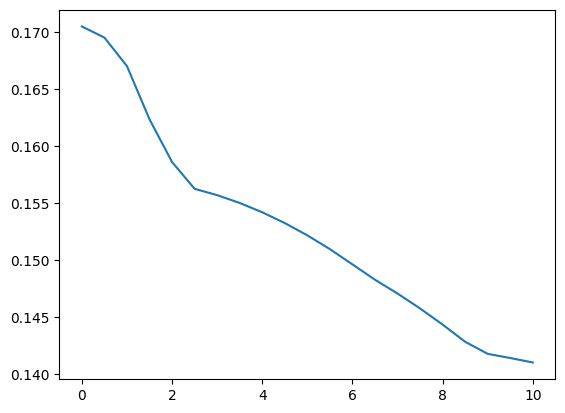

In [50]:
plt.plot(lasso_scores.keys(), lasso_scores.values())

Tuning the Lasso model suggests that higher alpha values lead to a decrease in accuracy. The strongest model tested had alpha = 0, which is identical to ordinary least squares regression.

### Decision trees

In [51]:
from sklearn.tree import DecisionTreeRegressor

trees = {}
for i in range(1,10):
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(X2_train, y2_train)
    trees[i] = dt.score(X2_test, y2_test)

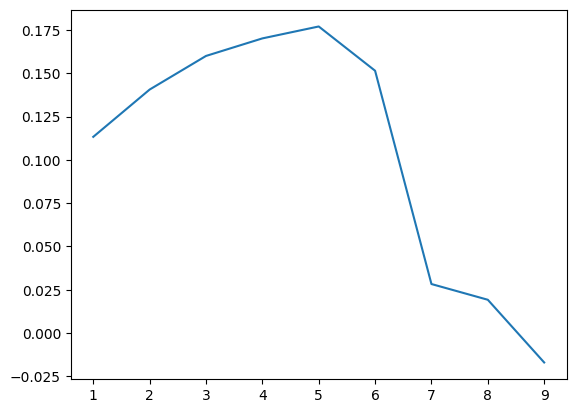

In [52]:
plt.plot(trees.keys(), trees.values())

In [53]:
dt5 = DecisionTreeRegressor(max_depth=5)
dt5.fit(X2_train, y2_train)
y2_pred_dt5 = dt5.predict(X2_test)

After tuning, the decision tree model has best performance with a maximum depth of 5.

# 4. Model evaluation

Tuning the Lasso model demonstrated that the strongest model was equivalent to ordinary least squares. The following evaluation therefore compares the ordinary least squares model to the decision tree model.

The specific challenge posed in this task is to estimate nightly prices for new properties within a threshold of USD25. Each model will be evaluated on the proportion of predicted values within USD25, USD50, and USD100 of the true value, and the mean and median absolute deviation from the true value.

### Ordinary least squares evaluation

In [54]:
y2_diff_lr = abs(y2_pred_lr - y2_test)
y2_diff_lr.describe()

count    1754.000000
mean       98.561829
std       258.376502
min         0.005665
25%        24.631821
50%        55.014416
75%       104.973006
max      7906.862772
Name: price_float, dtype: float64

The most accurate predictions from the least squares model are within one cent of the true value. However, the mean absolute deviation from the true price is nearly USD100. Half the predictions are out by more than USD55.

In [55]:
lr_perc_25 = round(100*sum(y2_diff_lr <= 25)/len(y2_diff_lr),1)
lr_perc_50 = round(100*sum(y2_diff_lr <= 50)/len(y2_diff_lr),1)
lr_perc_100 = round(100*sum(y2_diff_lr <= 100)/len(y2_diff_lr),1)
print(f"{lr_perc_25}% of the OLS model predictions are within $25 of the true value. \n{lr_perc_50}% of the OLS model predictions are within $50 of the true value. \n{lr_perc_100}% of the OLS model predictions are within $100 of the true value.")

25.4% of the OLS model predictions are within $25 of the true value. 
46.1% of the OLS model predictions are within $50 of the true value. 
73.8% of the OLS model predictions are within $100 of the true value.


### Decision tree evaluation

In [56]:
y2_diff_dt5 = abs(y2_pred_dt5 - y2_test)
y2_diff_dt5.describe()

count    1754.000000
mean       94.447704
std       258.692866
min         0.022465
25%        24.115431
50%        49.855102
75%        88.130548
max      7885.884569
Name: price_float, dtype: float64

On initial inspection, the decision tree model appears to do a better job of predicting nightly rents. The mean and median deviations from the true values are slightly smaller than the OLS model predictions.

In [57]:
dt_perc_25 = round(100*sum(y2_diff_dt5 <= 25)/len(y2_diff_dt5),1)
dt_perc_50 = round(100*sum(y2_diff_dt5 <= 50)/len(y2_diff_dt5),1)
dt_perc_100 = round(100*sum(y2_diff_dt5 <= 100)/len(y2_diff_dt5),1)
print(f"{dt_perc_25}% of the decision tree model predictions are within $25 of the true value. \n{dt_perc_50}% of the decision tree model predictions are within $50 of the true value. \n{dt_perc_100}% of the decision tree model predictions are within $100 of the true value.")

26.1% of the decision tree model predictions are within $25 of the true value. 
50.3% of the decision tree model predictions are within $50 of the true value. 
78.6% of the decision tree model predictions are within $100 of the true value.


## Data evaluation summary

- The decision tree model performs better than OLS
- Its predictions deviate less from the true rent values on average
- However, neither model can predict values within USD25 of the true rent value more than around 26% of the time

# 5. Comparison with success criteria and recommendations

Neither model predicts nightly rents within USD25 of the true value more than around 26% of the time. 

On this basis, the task has not been completed successfully.

However, this analysis can form the basis of future analysis. I recommend the following next steps:
- Publish a tool on the Inn the Neighborhood website that allows potential customers to predict their nightly rent as a USD100 range. Evaluation of the decision tree model suggests this estimate should be correct around in around 50% of cases.
- Continue to collect listings data as the site grows to expand the training data.
- Collect data on markets outside downtown San Francisco to build a model applicable for customers outside that market.
- Short-stay property demand is highly seasonal. The nightly rents users can achieve will likely vary substantially through different times of year. Inn the Neighborhood should start collecting data on when listings are offered to determine whether this seasonality has a significant impact on nightly rents, which may be useful when predicting rents for new users.